### Extension Project will address Bluebikes correlation with Bus performance.

With this, we will be using Bluebikes station and trip datasets along with previous data about bus given in Bus performance project document.

#### Subproblem 1: Worst on-time Performance Routes correlation with Bluebikes usage

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
from collections import defaultdict
import os

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')
dir_path = '/content/MyDrive/MyDrive/City of Boston: Transit & Performance A/Data Files/deliverable_3_data'
files = os.listdir(dir_path)

Mounted at /content/MyDrive


In [ ]:
blue_bikes_trips = pd.read_csv(os.path.join(dir_path, '202201-bluebikes-tripdata.csv'))
mbta_prediction_accuracy = pd.read_csv(os.path.join(dir_path, 'Bus_Prediction_Accuracy.csv'))
census_neighbourhood = pd.read_csv(os.path.join(dir_path, 'Census-Boston-Neighborhood.csv'))
blue_bikes_stations = pd.read_csv(os.path.join(dir_path, 'current_bluebikes_stations.csv'))
mbta_reliability = pd.read_csv(os.path.join(dir_path, 'MBTA_Bus_Reliability.csv'))
mbta_gtfs = pd.read_csv(os.path.join(dir_path, 'MBTA_Systemwide_GTFS_Map.csv'))

In [ ]:
# folder_path = "../../data/"
# blue_bikes_trips = pd.read_csv(f"{folder_path}/202201-bluebikes-tripdata.csv")
# blue_bikes_stations = pd.read_csv(f"{folder_path}/current_bluebikes_stations.csv")
# census_neighbourhood = pd.read_csv(f"{folder_path}/Census-Boston-Neighborhood.csv")
# mbta_gtfs = pd.read_csv(f"{folder_path}/MBTA_Systemwide_GTFS_Map.csv")
# mbta_reliability = pd.read_csv(f"{folder_path}/MBTA_Bus_Reliability.csv")
# mbta_prediction_accuracy = pd.read_csv(f"{folder_path}/Bus_Prediction_Accuracy.csv")


In [ ]:
def process_blue_bikes_trips(blue_bikes_trips):
	processed_blue_bikes_trips = blue_bikes_trips
	processed_blue_bikes_trips["tripduration"] = blue_bikes_trips["tripduration"] / 60
	return processed_blue_bikes_trips

processed_blue_bikes_trips = process_blue_bikes_trips(blue_bikes_trips)
processed_blue_bikes_trips.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code
0,9.950000,2022-01-01 00:00:25.1660,2022-01-01 00:10:22.1920,178,MIT Pacific St at Purrington St,42.359573,-71.101295,74,Harvard Square at Mass Ave/ Dunster,42.373268,-71.118579,4923,Subscriber,02139
1,6.850000,2022-01-01 00:00:40.4300,2022-01-01 00:07:32.1980,189,Kendall T,42.362428,-71.084955,178,MIT Pacific St at Purrington St,42.359573,-71.101295,3112,Subscriber,02139
2,7.933333,2022-01-01 00:00:54.8180,2022-01-01 00:08:51.6680,94,Main St at Austin St,42.375603,-71.064608,356,Charlestown Navy Yard,42.374125,-71.054812,6901,Customer,02124
3,7.766667,2022-01-01 00:01:01.6080,2022-01-01 00:08:48.2350,94,Main St at Austin St,42.375603,-71.064608,356,Charlestown Navy Yard,42.374125,-71.054812,5214,Customer,02124
4,12.533333,2022-01-01 00:01:06.0520,2022-01-01 00:13:38.2300,19,Park Dr at Buswell St,42.347241,-71.105301,41,Packard's Corner - Commonwealth Ave at Brighto...,42.352261,-71.123831,2214,Subscriber,02215


In [ ]:
# print(blue_bikes_stations.head())

def process_blue_bikes_stations(blue_bikes_stations, blue_bikes_trips):
	# Fixing first row as the column names
	new_column_names = blue_bikes_stations.iloc[0]  # Get the first row to use as column names
	blue_bikes_stations.columns = new_column_names  # Set new column names
	blue_bikes_stations = blue_bikes_stations.iloc[1:].reset_index(drop=True)

	# Extracting the unique start station names and IDs
	start_stations = blue_bikes_trips[['start station id', 'start station name']].drop_duplicates()
	start_stations = start_stations.rename(columns={'start station id': 'station_id', 'start station name': 'station_name'})

	# Extracting the unique end station names and IDs.
	end_stations = blue_bikes_trips[['end station id', 'end station name']].drop_duplicates()
	end_stations = end_stations.rename(columns={'end station id': 'station_id', 'end station name': 'station_name'})

	# Combining the start and end station information.
	combined_stations = pd.concat([start_stations, end_stations]).drop_duplicates().set_index('station_name')
	blue_bikes_stations['station_id'] = blue_bikes_stations['Name'].map(combined_stations['station_id'])
	blue_bikes_stations = blue_bikes_stations.dropna(subset = ["station_id"])
	return blue_bikes_stations

processed_blue_bikes_stations = process_blue_bikes_stations(blue_bikes_stations, processed_blue_bikes_trips)
processed_blue_bikes_stations.head()


,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year,station_id
0,K32015,1200 Beacon St,42.34414899,-71.11467361,Brookline,Yes,1,2021,452.0
1,W32006,160 Arsenal,42.36466403,-71.17569387,Watertown,Yes,11,2021,502.0
2,A32019,175 N Harvard St,42.36447457,-71.12840831,Boston,Yes,17,2014,149.0
3,S32035,191 Beacon St,42.38032335,-71.10878613,Somerville,Yes,19,2018,378.0
4,C32094,2 Hummingbird Lane at Olmsted Green,42.28887,-71.095003,Boston,Yes,17,2020,493.0


In [ ]:
census_neighbourhood.head()

,tract20_nbhd,P0020001,P0020005,P0020006,P0020002,P002aapi,P002others,P0040001,P0040005,P0040006,...,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,H0010001,H0010002,H0010003,hhsize
0,field concept,Total:,White alone,Black or African American alone,Hispanic or Latino,"Asian, Native Hawaiian and Pacific Islander al...","Other Races or Multiple Races, all ages",Total:,White alone,Black or African American alone,...,Nursing facilities/Skilled-nursing facilities,Other institutional facilities,Noninstitutionalized population:,College/University student housing,Military quarters,Other noninstitutional facilities,Total:,Occupied,Vacant,household size
1,Allston,24904,12536,1326,3259,6271,1512,23140,11976,1184,...,0,0,3281,3214,0,67,10748,10027,721,2.156477511
2,Back Bay,18190,13065,690,1208,2410,817,17042,12349,641,...,269,0,1610,1487,0,123,11524,10006,1518,1.630121927
3,Beacon Hill,9336,7521,252,537,630,396,8603,6980,231,...,0,0,33,0,0,33,6037,5485,552,1.696080219
4,Brighton,52047,32694,2414,5376,8703,2860,47657,30752,2076,...,266,56,3796,3493,0,303,23653,22535,1118,2.126292434


In [ ]:
mbta_gtfs.head()

def process_gtfs(MBTA_data):
	MBTA_data = MBTA_data[MBTA_data['Neighborhood'].notnull()]
	MBTA_data = MBTA_data[MBTA_data['Routes'] != '#N/A']
	MBTA_data = MBTA_data[MBTA_data['Routes'].notnull()]

	# Split routes column to separate routes
	MBTA_data['Routes'] = MBTA_data['Routes'].str.split('|')
	MBTA_data = MBTA_data.explode('Routes')
	df = MBTA_data[["stop_id", "stop_name", "stop_lat", "stop_lon", "Neighborhood", "Routes"]]

	return df

processed_mbta_gtfs = process_gtfs(mbta_gtfs)
processed_mbta_gtfs.head()


,stop_id,stop_name,stop_lat,stop_lon,Neighborhood,Routes
0,1,Washington St opp Ruggles St,42.330957,-71.082754,Roxbury,1
0,1,Washington St opp Ruggles St,42.330957,-71.082754,Roxbury,8
0,1,Washington St opp Ruggles St,42.330957,-71.082754,Roxbury,10
0,1,Washington St opp Ruggles St,42.330957,-71.082754,Roxbury,47
0,1,Washington St opp Ruggles St,42.330957,-71.082754,Roxbury,19


In [ ]:
mbta_prediction_accuracy.head()

,weekly,mode,route_id,bin,arrival_departure,num_predictions,num_accurate_predictions,ObjectId
0,2021/08/13 04:00:00+00,bus,NaN,0-3 min,departure,293039,233562,1
1,2021/08/13 04:00:00+00,bus,NaN,3-6 min,departure,285817,229090,2
2,2021/08/13 04:00:00+00,bus,NaN,6-12 min,departure,561098,472923,3
3,2021/08/13 04:00:00+00,bus,NaN,12-30 min,departure,1594830,1405620,4
4,2021/08/20 04:00:00+00,bus,NaN,0-3 min,departure,285591,228653,5


In [ ]:
mbta_reliability.head()

# Code taken from Base Question 2 code
def process_reliability(df):
	new_df = df[df["mode_type"]=="Bus"] # taking only buses
	new_df = new_df.dropna(subset=['otp_denominator', 'otp_numerator','cancelled_numerator']) # No NaN / Null
	new_df['ot_rate'] = new_df['otp_numerator']/new_df['otp_denominator']
	grouped_route = new_df.groupby('gtfs_route_id')
	grouped_rate = grouped_route['ot_rate'].mean().reset_index()
	rate_sorted = grouped_rate.sort_values(by='ot_rate', ascending=False)
	return rate_sorted


reliability_rate_sorted = process_reliability(mbta_reliability)

reliability_rate_sorted.head() # best ot_rate
reliability_rate_sorted.tail() # worst ot_rate


,gtfs_route_id,ot_rate
150,747,0.458202
106,459,0.429970
99,448,0.406302
100,449,0.402552
178,9703,0.320094


#### We have the best and worst on-time performance data extracted from base question 2 - Utilizes the MBTA Reliability Dataset:

Best 10:

![image-2.png](attachment:image-2.png)

Worst 10:

![image.png](attachment:image.png)



In [ ]:
merged_data_on_routes = pd.merge(processed_mbta_gtfs, reliability_rate_sorted, left_on = "Routes", right_on = "gtfs_route_id")

print(merged_data_on_routes['gtfs_route_id'].isna().sum()) # checking no bus routes are not included in the relability dataset.
print(merged_data_on_routes['Routes'].isna().sum()) # checking no bus routes are not included in the GTFS dataset.

merged_data_on_routes.head()


0
0


,stop_id,stop_name,stop_lat,stop_lon,Neighborhood,Routes,gtfs_route_id,ot_rate
0,1,Washington St opp Ruggles St,42.330957,-71.082754,Roxbury,1,1,0.744301
1,10003,Albany St opp Randall St,42.331591,-71.076237,Roxbury,1,1,0.744301
2,10100,Albany St @ Randall St,42.331675,-71.076347,Roxbury,1,1,0.744301
3,10101,Melnea Cass Blvd @ Harrison Ave,42.332066,-71.079147,Roxbury,1,1,0.744301
4,10590,Massachusetts Ave @ Washington St,42.336621,-71.076956,South End,1,1,0.744301


In [ ]:
# Group by 'Routes'
grouped_by_routes = merged_data_on_routes.groupby('Routes')

grouped_by_routes.head()

# # Aggregate 'ot_rate' for each route, then sort to find the worst 10
# # Assuming 'worst' means the highest values
worst_routes = grouped_by_routes['ot_rate'].mean().sort_values(ascending=True)
best_routes = grouped_by_routes['ot_rate'].mean().sort_values(ascending=False)

# # Print the worst 10 routes based on ot_rate
print(worst_routes.head(10))
# # Print the best 10 routes based on ot_rate
print(best_routes.head(10))

Routes
9703    0.320094
449     0.402552
448     0.406302
459     0.429970
747     0.458202
41      0.488934
19      0.493452
70A     0.494182
14      0.509825
701     0.515090
Name: ot_rate, dtype: float64
Routes
742    0.837185
502    0.813195
32     0.807782
749    0.807251
111    0.803600
751    0.801902
741    0.801389
746    0.800187
7      0.792366
31     0.786380
Name: ot_rate, dtype: float64


In [ ]:
worst_routes_loc = pd.merge(worst_routes, merged_data_on_routes, left_on = ["Routes", "ot_rate"], right_on = ["Routes", "ot_rate"])
worst_routes_loc.rename(columns={"Routes": "route"}, inplace=True)
worst_routes_loc.head(25) # rows are per stop, so showing more rows ensures the visibility of other routes here beyond route 9703
# print(worst_routes_loc.shape)


,route,ot_rate,stop_id,stop_name,stop_lat,stop_lon,Neighborhood,gtfs_route_id
0,9703,0.320094,1111,Cambridge St opp Hano St,42.353931,-71.136365,Allston,9703
1,9703,0.320094,1112,Cambridge St @ Harvard St,42.355641,-71.132361,Allston,9703
2,9703,0.320094,1113,Cambridge St @ Linden St,42.355943,-71.131448,Allston,9703
3,9703,0.320094,1114,Cambridge St @ N Harvard St,42.357758,-71.126505,Allston,9703
4,9703,0.320094,11388,Huntington Ave @ Belvidere St,42.345344,-71.082045,Back Bay,9703
5,9703,0.320094,1257,Tremont St @ Prentiss St,42.332930,-71.092638,Roxbury,9703
6,9703,0.320094,1258,Tremont St @ Roxbury Crossing Station,42.331311,-71.094831,Roxbury,9703
7,9703,0.320094,1260,Columbus Ave @ New Cedar St,42.328067,-71.097310,Roxbury,9703
8,9703,0.320094,1262,Columbus Ave @ Heath St,42.325028,-71.098483,Roxbury,9703
9,9703,0.320094,1784,Ruggles St @ Huntington Ave,42.337416,-71.095079,Mission Hill,9703


From here, we will be comparing locations of bus stations of the worst routes and the locations of bluebikes going along those routes. We will then see the average number of rides in that station.

In [ ]:
best_routes_loc = pd.merge(best_routes, merged_data_on_routes, left_on = ["Routes", "ot_rate"], right_on = ["Routes", "ot_rate"])
best_routes_loc.rename(columns={"Routes": "route"}, inplace=True)
best_routes_loc.head(25) # rows are per stop, so showing more rows ensures the visibility of other routes here beyond route 9703
# print(worst_routes_loc.shape)


,route,ot_rate,stop_id,stop_name,stop_lat,stop_lon,Neighborhood,gtfs_route_id
0,502,0.813195,178,Saint James Ave @ Dartmouth St,42.349505,-71.076639,Back Bay,502
1,502,0.813195,71855,Stuart St @ Dartmouth St,42.348245,-71.076218,Back Bay,502
2,32,0.807782,10522,Circuit Dr @ Glen Ln,42.305104,-71.094684,Roxbury,32
3,32,0.807782,11131,Centre St @ Roseway St,42.318993,-71.111932,Jamaica Plain,32
4,32,0.807782,1128,South St @ Sedgwick St,42.308588,-71.115487,Jamaica Plain,32
5,32,0.807782,1129,Centre St @ Seaverns Ave,42.312198,-71.114144,Jamaica Plain,32
6,32,0.807782,1130,Centre St @ Saint John St,42.314462,-71.114046,Jamaica Plain,32
7,32,0.807782,1132,Centre St opp Beaufort Rd,42.316493,-71.113660,Jamaica Plain,32
8,32,0.807782,11587,Circuit Dr @ Glen Ln,42.305236,-71.094725,Roxbury,32
9,32,0.807782,11780,Ave Louis Pasteur @ Longwood Ave,42.337969,-71.102457,Longwood,32


We also do the same for the best routes to provide a point of comparison.

In [ ]:
# This formula is used to take distances between locations (using longitude and latitude)

def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Earth radius in km
    dlon = np.radians(lon2 - lon1)
    dlat = np.radians(lat2 - lat1)
    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    return distance


# This formula will be used to test if bluebikes stations are within a 10 minute walk away from any of the worst route stops.
def no_more_than_x_mins(distance, x):
    max_walking_distance = x / 60  * 5 # assuming a walking speed of 5 km/h.
    return distance <= max_walking_distance

In [ ]:
MAX_WALKING_DISTANCE = 10 # in minutes

close_blue_bikes_list = defaultdict(list)
# Comparing the locations:
for _, bus_stop in worst_routes_loc.iterrows():
    # Extract latitude and longitude for the bus stop
    bus_stop_lat, bus_stop_lon = float(bus_stop['stop_lat']), float(bus_stop['stop_lon'])

    # Iterate through each blue bike station
    for _, bike_station in processed_blue_bikes_stations.iterrows():
        # Extract latitude and longitude for the bike station
        bike_station_lat, bike_station_lon = float(bike_station['Latitude']), float(bike_station['Longitude'])

        # Calculate the distance between the bus stop and the bike station
        distance = haversine(bus_stop_lon, bus_stop_lat, bike_station_lon, bike_station_lat)

        if no_more_than_x_mins(distance, MAX_WALKING_DISTANCE):
            if (bike_station['station_id'] not in close_blue_bikes_list[bus_stop["route"]]): # taking only the distinct stops
                close_blue_bikes_list[bus_stop["route"]].append(bike_station["station_id"])



In [ ]:
close_blue_bikes_list_best = defaultdict(list)
# Comparing the locations:
for _, bus_stop in best_routes_loc.iterrows():
    # Extract latitude and longitude for the bus stop
    bus_stop_lat, bus_stop_lon = float(bus_stop['stop_lat']), float(bus_stop['stop_lon'])

    # Iterate through each blue bike station
    for _, bike_station in processed_blue_bikes_stations.iterrows():
        # Extract latitude and longitude for the bike station
        bike_station_lat, bike_station_lon = float(bike_station['Latitude']), float(bike_station['Longitude'])

        # Calculate the distance between the bus stop and the bike station
        distance = haversine(bus_stop_lon, bus_stop_lat, bike_station_lon, bike_station_lat)

        if no_more_than_x_mins(distance, MAX_WALKING_DISTANCE):
            if (bike_station['station_id'] not in close_blue_bikes_list_best[bus_stop["route"]]): # taking only the distinct stops
                close_blue_bikes_list_best[bus_stop["route"]].append(bike_station["station_id"])



In [ ]:
print(len(close_blue_bikes_list_best['111']))

13


In [ ]:
start_trip_count = blue_bikes_trips.groupby('start station id')["start station id"].count()
end_trip_count = blue_bikes_trips.groupby('end station id')["end station id"].count()

trip_counts = pd.concat([start_trip_count, end_trip_count], axis = 1)
trip_counts.columns = ['start_trip_count', 'end_trip_count']
trip_counts["difference"] = trip_counts["end_trip_count"] - trip_counts["start_trip_count"] # Negative means more stations that people pick up bikes from.
print(trip_counts.head(10))

    start_trip_count  end_trip_count  difference
3              199.0           211.0        12.0
4              349.0           374.0        25.0
6              644.0           601.0       -43.0
7               69.0            78.0         9.0
8              269.0           271.0         2.0
9              800.0           822.0        22.0
10             428.0           434.0         6.0
11             609.0           638.0        29.0
12             502.0           492.0       -10.0
14             586.0           620.0        34.0


In [ ]:
# Get the list of best routes (e.g., top 10)
top_best_routes = best_routes.head(12).index.tolist()
print(top_best_routes)
# Filter close_blue_bikes_list for these routes
best_route_stations = {route: stations for route, stations in close_blue_bikes_list_best.items() if route in top_best_routes}
print(len(best_route_stations))
# Flatten the dictionary to a list of tuples (route, station_id)
route_station_pairs = [(route, station_id) for route, stations in best_route_stations.items() for station_id in stations]

# Convert to DataFrame
route_station_df = pd.DataFrame(route_station_pairs, columns=['route', 'station_id'])

# Merge with trip_counts
relevant_trip_counts_best = route_station_df.merge(trip_counts, left_on='station_id', right_index=True)


['742', '502', '32', '749', '111', '751', '741', '746', '7', '31', '15', '39']
9


In [ ]:
# Get the list of best routes (e.g., top 10)
top_worst_routes = worst_routes.head(12).index.tolist()
print(top_worst_routes)
# Filter close_blue_bikes_list for these routes
worst_route_stations = {route: stations for route, stations in close_blue_bikes_list.items() if route in top_worst_routes}
print(len(worst_route_stations))
# Flatten the dictionary to a list of tuples (route, station_id)
route_station_pairs_worst = [(route, station_id) for route, stations in worst_route_stations.items() for station_id in stations]

# Convert to DataFrame
route_station_df_worst = pd.DataFrame(route_station_pairs_worst, columns=['route', 'station_id'])

# Merge with trip_counts
relevant_trip_counts_worst = route_station_df_worst.merge(trip_counts, left_on='station_id', right_index=True)


['9703', '449', '448', '459', '747', '41', '19', '70A', '14', '701', '8', '354']
10


In [ ]:
# Example: Calculate the mean difference for each route
mean_differences_best = relevant_trip_counts_best.groupby('route')['difference'].mean()
print(mean_differences_best)

route
111    -9.076923
15      4.833333
31     -1.100000
32     -3.472222
39     14.173913
502    33.857143
746     5.909091
749     4.025641
751     8.459459
Name: difference, dtype: float64


In [ ]:
# Example: Calculate the mean difference for each route
mean_differences_worst = relevant_trip_counts_worst.groupby('route')['difference'].mean()
print(mean_differences_worst)

route
14      -7.384615
19       2.916667
354     -0.684211
41      -2.904762
448      4.833333
459      4.833333
701     15.076923
747      3.240000
8        4.682927
9703     6.181818
Name: difference, dtype: float64


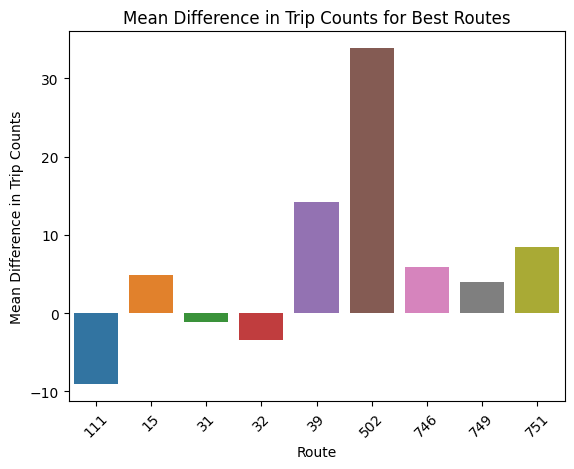

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x=mean_differences_best.index, y=mean_differences_best.values)
plt.xticks(rotation=45)
plt.xlabel('Route')
plt.ylabel('Mean Difference in Trip Counts')
plt.title('Mean Difference in Trip Counts for Best Routes')
plt.show()


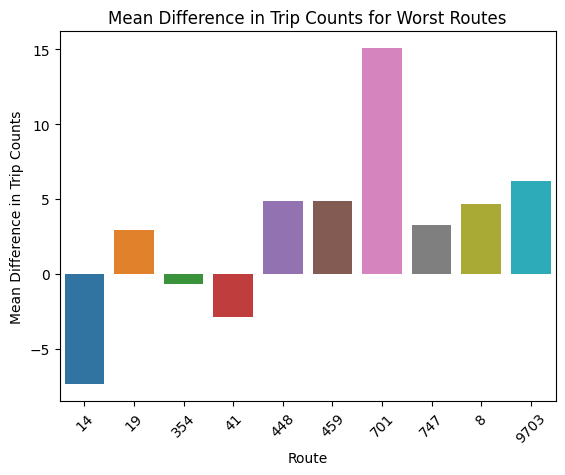

In [ ]:
#Plot mean difference for worst routes
sns.barplot(x=mean_differences_worst.index, y=mean_differences_worst.values)
plt.xticks(rotation=45)
plt.xlabel('Route')
plt.ylabel('Mean Difference in Trip Counts')
plt.title('Mean Difference in Trip Counts for Worst Routes')
plt.show()


In [ ]:
mean_diff = trip_counts['difference'].mean()
median_diff = trip_counts['difference'].median()
std_diff = trip_counts['difference'].std()

print("Mean difference:", mean_diff)
print("Median difference:", median_diff)
print("Standard deviation:", std_diff)

Mean difference: 0.005747126436781609
Median difference: 1.0
Standard deviation: 30.98414526724328


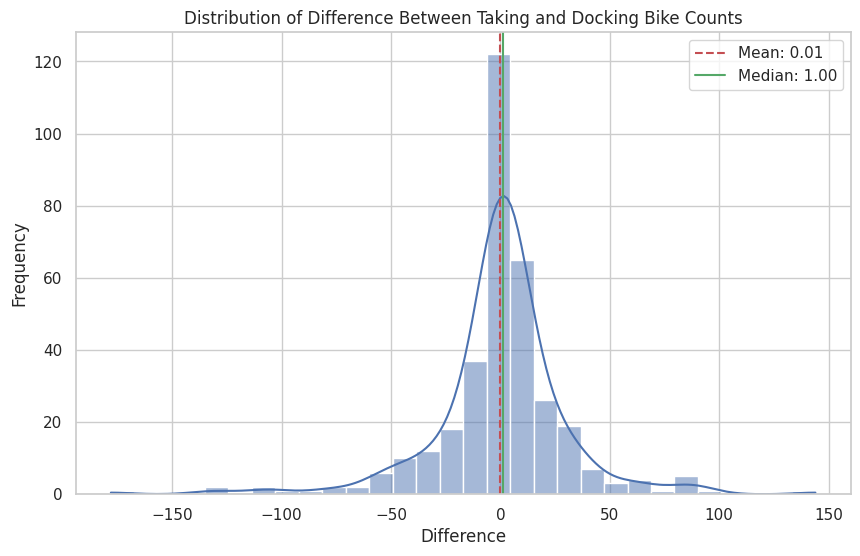

In [ ]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(trip_counts['difference'], kde=True, bins=30)

# Add titles and labels
plt.title('Distribution of Difference Between Taking and Docking Bike Counts')
plt.xlabel('Difference')
plt.ylabel('Frequency')

# Show mean and median in the plot
plt.axvline(mean_diff, color='r', linestyle='--', label=f"Mean: {mean_diff:.2f}")
plt.axvline(median_diff, color='g', linestyle='-', label=f"Median: {median_diff:.2f}")

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(blue_bikes_trips)

# Create a box plot for the 'tripduration' column
plt.figure(figsize=(10, 6))
plt.boxplot(df['tripduration'], vert=False)  # 'vert=False' makes the box plot horizontal
plt.title('Box plot of Trip Durations')
plt.xlabel('Duration (in hours)')
plt.show()


NameError: ignored

###Blue Bike Station Duration


In [ ]:
avg_trip_duration_start = blue_bikes_trips.groupby('start station id')['tripduration'].mean().reset_index()
avg_trip_duration_start.rename(columns={'start station id': 'station_id', 'tripduration': 'avg_start_duration'}, inplace=True)

# Calculate average trip duration for end stations
avg_trip_duration_end = blue_bikes_trips.groupby('end station id')['tripduration'].mean().reset_index()
avg_trip_duration_end.rename(columns={'end station id': 'station_id', 'tripduration': 'avg_end_duration'}, inplace=True)

# Merge the two dataframes on station_id
merged_avg_durations = pd.merge(avg_trip_duration_start, avg_trip_duration_end, on='station_id', how='outer')

# Calculating the mean of the two averages, handling cases where one might be NaN
merged_avg_durations['avg_trip_duration'] = merged_avg_durations[['avg_start_duration', 'avg_end_duration']].mean(axis=1, skipna=True)

bike_station_avg_usage = merged_avg_durations[['station_id', 'avg_trip_duration']].set_index('station_id').to_dict()['avg_trip_duration']

print(bike_station_avg_usage)


{3: 17.033690569752395, 4: 13.714920526689447, 6: 16.092184695624614, 7: 24.113113154960978, 8: 26.39300207593154, 9: 13.660425359894566, 10: 12.3289057452948, 11: 22.37370254266806, 12: 15.193988072101838, 14: 14.413497926529413, 15: 17.79285580524345, 16: 15.107208225034721, 17: 26.065753492642497, 19: 32.4173069813575, 20: 19.292263427109976, 21: 22.845110646958013, 22: 34.416340305892945, 23: 14.552135733169958, 24: 61.77415149602463, 25: 10.362235343575632, 26: 10.782945493277047, 27: 11.519996476391825, 29: 12.60202026901826, 30: 14.781514656544417, 31: 11.868469877234421, 32: 13.769010866910428, 33: 17.422139941654457, 36: 14.546961805555554, 37: 212.60039062499996, 39: 17.213605736100774, 40: 14.827959016855516, 41: 18.475649803892978, 42: 28.56688916321633, 43: 24.48252290448343, 44: 108.77078105847573, 46: 14.699977289479595, 47: 14.630674511398581, 49: 18.785899901735213, 51: 11.948253560126583, 54: 72.41685397935399, 55: 13.833070552811138, 56: 142.15872774397116, 58: 21.47

In [ ]:
# Calculate the average trip duration for each best route
best_route_avg_durations = {}
for route, station_ids in best_route_stations.items():
    total_duration = 0
    count = 0
    for station_id in station_ids:
        if station_id in bike_station_avg_usage:
            total_duration += bike_station_avg_usage[station_id]
            count += 1
    if count > 0:
        best_route_avg_durations[route] = total_duration / count

# Convert to a DataFrame for easy plotting
best_route_durations_df = pd.DataFrame(list(best_route_avg_durations.items()), columns=['route', 'avg_duration'])


In [ ]:
# Sort and select the top 10 best routes
top_10_best_routes = best_route_durations_df.sort_values(by='avg_duration').head(10)


AttributeError: ignored

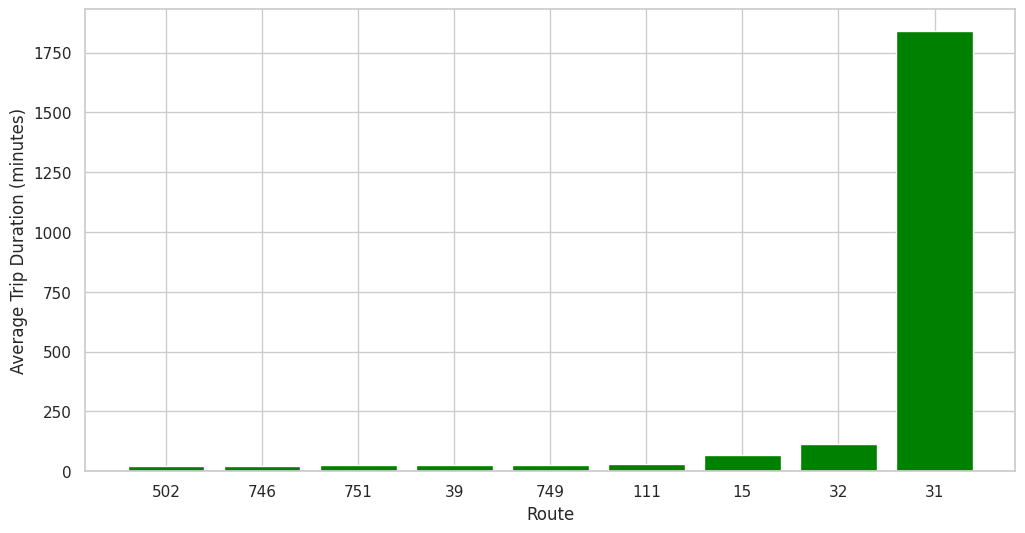

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
plt.bar(top_10_best_routes['route'], top_10_best_routes['avg_duration'], color='green')
plt.xlabel('Route')
plt.ylabel('Average Trip Duration (minutes)')
plt.y
plt.title('Average Trip Duration for Top 10 Best Routes')
plt.xticks(rotation=45)
plt.show()